Titanic Machine Learning Data Trainer
- In this notebook, we will analyze the test data and attempt to predict the outcomes for the missing people. Given the data we have, can we accurately predict whether the rest of the people lived or died?
- First, we will want to do manual research on the data we have. Are there any trends (gender, ticket class, age, etc.) that represent a strong-ish correlation with survival rate?

Data Information

(1) train.csv
- train.csv contains the details of a subset of the passengers on board (891 passengers, to be exact -- where each passenger gets a different row in the table).

- The values in the second column ("Survived") can be used to determine whether each passenger survived or not:
- if it's a "1", the passenger survived.
- if it's a "0", the passenger died.

(2) test.csv
- Using the patterns you find in train.csv, you have to predict whether the other 418 passengers on board (in test.csv) survived.

- Note that test.csv does not have a "Survived" column - this information is hidden from you, and how well you do at predicting these hidden values will determine how highly you score in the competition!

(3) gender_submission.csv
- The gender_submission.csv file is provided as an example that shows how you should structure your predictions. It predicts that all female passengers survived, and all male passengers died. Your hypotheses regarding survival will probably be different, which will lead to a different submission file. But, just like this file, your submission should have:

- a "PassengerId" column containing the IDs of each passenger from test.csv.
- a "Survived" column (that you will create!) with a "1" for the rows where you think the passenger survived, and a "0" where you predict that the passenger died.



In [226]:
import numpy as np
import pandas as pd
import os
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import LeakyReLU

In [227]:
test_data = pd.read_csv("test.csv")
test_data.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [228]:
train_data = pd.read_csv("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


First, we will create a correlation matrix to show the overall relationship between various features and survival:

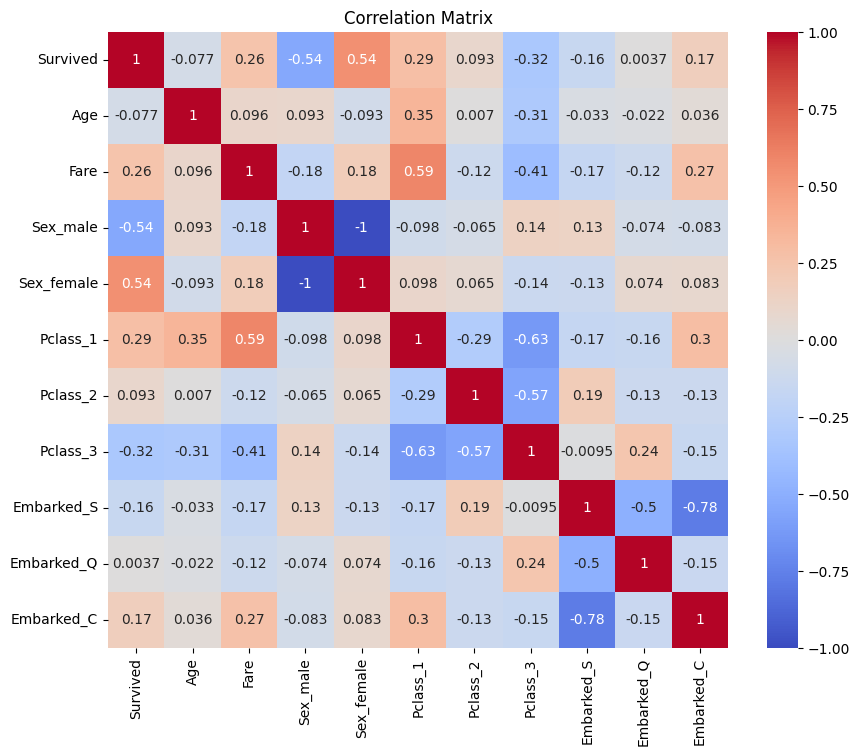

In [229]:
df_dummies = pd.get_dummies(train_data, columns=['Pclass', 'Sex', 'Embarked'])

correlation_matrix = df_dummies[[
    'Survived',
    'Age',
    'Fare',
    'Sex_male',
    'Sex_female',
    'Pclass_1',
    'Pclass_2',
    'Pclass_3',
    'Embarked_S',
    'Embarked_Q',
    'Embarked_C',
    ]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

Looking at passenger age in relation to their ticket class (Pclass):

<Axes: title={'center': 'Age'}, xlabel='Pclass'>

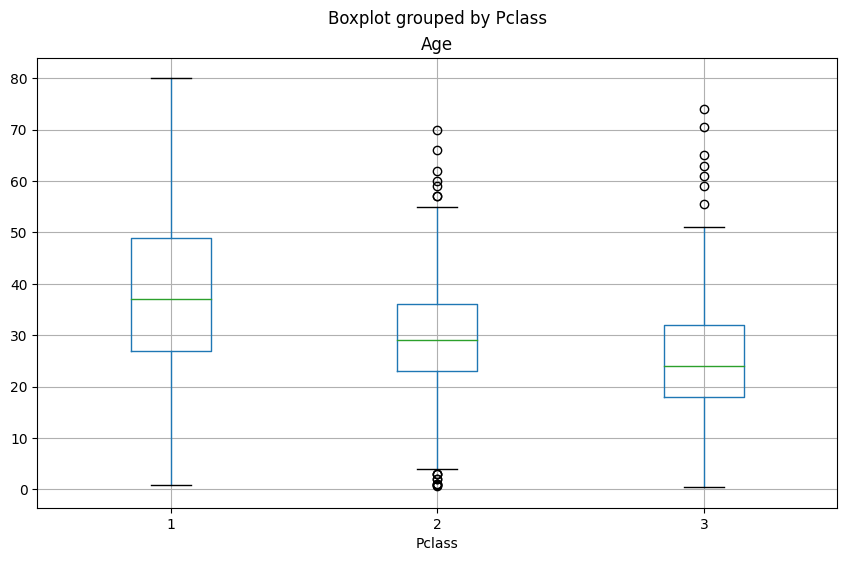

In [230]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
train_data.boxplot(column='Age', by='Pclass', ax=ax)

In [231]:
# Here, we are looking at the survival rate of each class
first_class = train_data.loc[train_data.Pclass == 1]["Survived"]
rate_first = sum(first_class)/len(first_class)

second_class = train_data.loc[train_data.Pclass == 2]["Survived"]
rate_second = sum(second_class)/len(second_class)

third_class = train_data.loc[train_data.Pclass == 3]["Survived"]
rate_third = sum(third_class)/len(third_class)

print("% of 1st class passengers that survived:", rate_first)
print("% of 2nd class passengers that survived:", rate_second)
print("% of 3rd class passengers that survived:", rate_third)

% of 1st class passengers that survived: 0.6296296296296297
% of 2nd class passengers that survived: 0.47282608695652173
% of 3rd class passengers that survived: 0.24236252545824846


Looking at the survival rates of first, second and third class passengers, there is clear correlation between a passenger's ticket class and likelihood to survive.

In [232]:
# Now, we want to see the rate of survival from each port to see if there is some connection there
print("Total # of C port passengers:", len(train_data.loc[train_data.Embarked == 'C']))
print("Total # of Q port passengers:", len(train_data.loc[train_data.Embarked == 'Q']))
print("Total # of S port passengers:", len(train_data.loc[train_data.Embarked == 'S']))

c_port = train_data.loc[train_data.Embarked == 'C']["Survived"]
rate_cport = sum(c_port)/len(c_port)

q_port = train_data.loc[train_data.Embarked == 'Q']["Survived"]
rate_qport = sum(q_port)/len(q_port)

s_port = train_data.loc[train_data.Embarked == 'S']["Survived"]
rate_sport = sum(s_port)/len(s_port)

print("% of C port passengers that survived:", rate_cport)
print("% of Q port passengers that survived:", rate_qport)
print("% of S port passengers that survived:", rate_sport)

Total # of C port passengers: 168
Total # of Q port passengers: 77
Total # of S port passengers: 644
% of C port passengers that survived: 0.5535714285714286
% of Q port passengers that survived: 0.38961038961038963
% of S port passengers that survived: 0.33695652173913043


Given the survival rates above, there is indeed some correlation between the port the passenger departed from and their likelihood to survive. Although the sample sizes between passengers from each port are not very similar in size, it is worth noting these differences and referencing this feature in our model.

In [233]:
# Now we will start to look at fare prices
# We will try to filter out some variables that might affect the price. It seems like Parch and SibSp is a high determining factor in the price, so we want to take this out of the equation for now.
# Let's look at the fare prices of people whose SibSp and Parch are 0.
# First, we are finding the average price of each class ticket so we have a range to go off of.

class_1 = train_data['Pclass'] == 1
class_2 = train_data['Pclass'] == 2
class_3 = train_data['Pclass'] == 3
no_parch = train_data['Parch'] == 0
no_sib = train_data['SibSp'] == 0

combined_cond1 = class_1 & no_parch & no_sib
filtered_cond1 = train_data[combined_cond1]
first_avg = filtered_cond1['Fare'].mean()


combined_cond2 = class_2 & no_parch & no_sib
filtered_cond2 = train_data[combined_cond2]
second_avg = filtered_cond2['Fare'].mean()


combined_cond3 = class_3 & no_parch & no_sib
filtered_cond3 = train_data[combined_cond3]
third_avg = filtered_cond3['Fare'].mean()

print("Average first class ticket without Parch and SibSp:", first_avg)
print("Average second class ticket without Parch and SibSp:", second_avg)
print("Average third class ticket without Parch and SibSp:", third_avg)

Average first class ticket without Parch and SibSp: 63.67251376146788
Average second class ticket without Parch and SibSp: 14.06610576923077
Average third class ticket without Parch and SibSp: 9.272051851851852


In [234]:
# Next, let's categorize those ticket cost averages as different rates, and look at survival.
high_rate = train_data.loc[train_data.Fare >= first_avg]["Survived"]
rate_high = sum(high_rate)/len(high_rate)

med_fare = train_data.loc[train_data.Fare < first_avg][train_data.Fare >= second_avg]["Survived"]
rate_med = sum(med_fare)/len(med_fare)

low_fare = train_data.loc[train_data.Fare <= third_avg]["Survived"]
rate_low = sum(low_fare)/len(low_fare)

print("% of people who survived and paid over $64:", rate_high)
print("% of people who survived and paid between $14 and $54:",  rate_med)
print("% of people who survived and paid below $14:", rate_low)

% of people who survived and paid over $64: 0.6864406779661016
% of people who survived and paid between $14 and $54: 0.44642857142857145
% of people who survived and paid below $14: 0.1962025316455696


/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_9991/869163461.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_fare = train_data.loc[train_data.Fare < first_avg][train_data.Fare >= second_avg]["Survived"]


Ater reviewing the correlation between ticket price and ticket class, it is evident that ticket price and ticket class play a factor in survival rate.

In [235]:
embarked_C = train_data['Embarked'] == 'C'
embarked_Q = train_data['Embarked'] == 'Q'
embarked_S = train_data['Embarked'] == 'S'

combined_condi1 = embarked_C & no_parch & no_sib
filtered_condi1 = train_data[combined_condi1]
c_port_avg = filtered_condi1['Fare'].mean()


combined_condi2 = embarked_Q & no_parch & no_sib
filtered_condi2 = train_data[combined_condi2]
q_port_avg = filtered_condi2['Fare'].mean()


combined_condi3 = embarked_S & no_parch & no_sib
filtered_condi3 = train_data[combined_condi3]
s_port_avg = filtered_condi3['Fare'].mean()


print("Average ticket price from port C without Parch and SibSp:", c_port_avg)
print("Average ticket price from port Q without Parch and SibSp:", q_port_avg)
print("Average ticket price from port S without Parch and SibSp:", s_port_avg)


Average ticket price from port C without Parch and SibSp: 49.75661882352942
Average ticket price from port Q without Parch and SibSp: 8.382970175438595
Average ticket price from port S without Parch and SibSp: 16.641684223918578


Zooming out a bit, we will next calculate the T-statistic to compare the mean prices of tickets for passengers that survived and those that did not, and confirm there is a significant difference:

In [236]:
survived_fare = train_data[train_data['Survived'] == 1]['Fare']
not_survived_fare = train_data[train_data['Survived'] == 0]['Fare']

t_stat, p_val = ttest_ind(survived_fare, not_survived_fare, nan_policy='omit')
print(f"T-stat: {t_stat} --- P-value: {p_val}")

T-stat: 7.939191660871055 --- P-value: 6.120189341924198e-15


With a P-value of essentially zero, we reject the null hypothesis and can confidently say that there is significant difference between the mean ticket prices of the survived and not survived groups.

Next, we will look into passenger gender, and see if it is correlated with survival rate:

In [237]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)
print("% of women who survived:", rate_women)

% of men who survived: 0.18890814558058924
% of women who survived: 0.7420382165605095


Given the above rates when comparing men and women, it is clear that gender is a highly correlated attribute to survival rate. Let's dive a little deeper into this, and see if age has any significant correlation.

In [238]:
child = train_data.loc[train_data.Age < 18]["Survived"]
rate_child = sum(child)/len(child)

print("% of children who survived:", rate_child)

% of children who survived: 0.5398230088495575


With a survival rate of ~50% for children (both male and female) under the age of 18, this does not tell us much. However, I have a feeling that this rate could be skewed by males that were closer to that age threshold (i.e. teenage boys). I could see a world where boys that were old enough to not be considered "children" may have not had priority spots on the lifeboats. Let's dig into this a bit further, and see if we can uncover any trends when considering age and gender:

In [239]:
child_male_sub_5 = train_data.loc[train_data.Age < 5][train_data.Sex == 'male']["Survived"]
rate_child_male_sub_5 = sum(child_male_sub_5)/len(child_male_sub_5)

child_male_sub_12 = train_data.loc[train_data.Age < 12][train_data.Sex == 'male']["Survived"]
rate_child_male_sub_12 = sum(child_male_sub_12)/len(child_male_sub_12)

child_male_sub_18 = train_data.loc[train_data.Age < 18][train_data.Sex == 'male']["Survived"]
rate_child_male_sub_18 = sum(child_male_sub_18)/len(child_male_sub_18)

print("% of boys who survived (under 5 years old):", rate_child_male_sub_5)
print("% of boys who survived (under 12 years old):", rate_child_male_sub_12)
print("% of boys who survived (under 18 years old):", rate_child_male_sub_18)

% of boys who survived (under 5 years old): 0.6521739130434783
% of boys who survived (under 12 years old): 0.5555555555555556
% of boys who survived (under 18 years old): 0.39655172413793105


/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_9991/975798654.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  child_male_sub_5 = train_data.loc[train_data.Age < 5][train_data.Sex == 'male']["Survived"]
/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_9991/975798654.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  child_male_sub_12 = train_data.loc[train_data.Age < 12][train_data.Sex == 'male']["Survived"]
/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_9991/975798654.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  child_male_sub_18 = train_data.loc[train_data.Age < 18][train_data.Sex == 'male']["Survived"]


Given these survival rates, it is evident that younger boys that could be considered babies/infants had a much higher chance of survival than older boys. Let's take a look at these same rates for girls:

In [240]:
child_female_sub_5 = train_data.loc[train_data.Age < 5][train_data.Sex == 'female']["Survived"]
rate_child_female_sub_5 = sum(child_female_sub_5)/len(child_female_sub_5)

child_female_sub_12 = train_data.loc[train_data.Age < 12][train_data.Sex == 'female']["Survived"]
rate_child_female_sub_12 = sum(child_female_sub_12)/len(child_female_sub_12)

child_female_sub_18 = train_data.loc[train_data.Age < 18][train_data.Sex == 'female']["Survived"]
rate_child_female_sub_18 = sum(child_female_sub_18)/len(child_female_sub_18)

print("% of girls who survived (under 5 years old):", rate_child_female_sub_5)
print("% of girls who survived (under 12 years old):", rate_child_female_sub_12)
print("% of girls who survived (under 18 years old):", rate_child_female_sub_18)

% of girls who survived (under 5 years old): 0.7058823529411765
% of girls who survived (under 12 years old): 0.59375
% of girls who survived (under 18 years old): 0.6909090909090909


/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_9991/851560439.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  child_female_sub_5 = train_data.loc[train_data.Age < 5][train_data.Sex == 'female']["Survived"]
/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_9991/851560439.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  child_female_sub_12 = train_data.loc[train_data.Age < 12][train_data.Sex == 'female']["Survived"]
/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_9991/851560439.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  child_female_sub_18 = train_data.loc[train_data.Age < 18][train_data.Sex == 'female']["Survived"]


Although there is a strange dip in the survival rate of girls between ages 5-11, it is notable that the survival rate of female babies/infants is very similar to the overall rate of girls under the age of 18. This goes to show that the age discrepancy between female childeren did not share the same impact on survival rate that it did on male children.

Overall, it is clear that the age of the passenger has significant correlation with the survival rate, especially when looking at gender and age together. We will want to keep that in mind when training our data. 

In [241]:
print(train_data.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Above, you can see the total count of rows missing values for the respective features (i.e. there are 177 rows missing a value for "Age"). We will want to make sure to clean these rows before using them in our model.

In [242]:
y = train_data["Survived"]
features = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('results-random-forest.csv', index=False)
print("results-random-forest.csv saved successfully")

results-random-forest.csv saved successfully


After submitting this results CSV file to Kaggle, we discovered that our Random Forest Classifier model successfully predicted the survival of 77.5% of our test data. While this is reasonably accurate, ideally we'd like to increase that accuracy rate by a bit. Let's try creating a sequential model using Keras and see how the results compare.

In [243]:
keras_train_data = pd.read_csv("train.csv")
keras_test_data = pd.read_csv("test.csv")

# Drop the fields we don't care about from the data
drop_fields = ['Ticket', 'Cabin', 'Name']
def clean_data(data, droppable):
    if pd.Series(droppable).isin(data.columns).all():  
        for field in droppable:
            data.drop(field, axis=1, inplace=True)
    return data

clean_data(keras_train_data, drop_fields)
clean_data(keras_test_data, drop_fields)

keras_train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


Now that we've cleaned our data, let's convert the categorical variables to numeric values. Our categorical variables are Sex and Embarked (both nominal). We'll use the get_dummies() function for this.

In [244]:
def convert_features(data, features):
    if pd.Series(features).isin(data.columns).all():
        data = pd.get_dummies(data, columns=features, drop_first=True)
    return data

nominal_features = ['Sex', 'Embarked']
keras_train_data = convert_features(keras_train_data, nominal_features)
keras_test_data = convert_features(keras_test_data, nominal_features)

# fill null values if any exist
keras_train_data.fillna(keras_train_data.mean(), inplace=True)
keras_test_data.fillna(keras_test_data.mean(), inplace=True)

# make sure the columns are aligned
keras_test_data = keras_test_data[keras_train_data.columns.drop('Survived')]

keras_test_data = keras_test_data.astype(np.float32)
keras_train_data = keras_train_data.astype(np.float32)

print(f'keras_train_data shape: {keras_train_data.shape}')
print(f'keras_test_data shape: {keras_test_data.shape}')

keras_train_data.head()


keras_train_data shape: (891, 10)
keras_test_data shape: (418, 9)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,1.0,0.0,3.0,22.0,1.0,0.0,7.250000,1.0,0.0,1.0
1,2.0,1.0,1.0,38.0,1.0,0.0,71.283302,0.0,0.0,0.0
2,3.0,1.0,3.0,26.0,0.0,0.0,7.925000,0.0,0.0,1.0
3,4.0,1.0,1.0,35.0,1.0,0.0,53.099998,0.0,0.0,1.0
4,5.0,0.0,3.0,35.0,0.0,0.0,8.050000,1.0,0.0,1.0


In [245]:
# Prepare data
X_train = keras_train_data.drop('Survived', axis=1)
y_train = keras_train_data['Survived']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(keras_test_data)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_train, test_size=0.2, random_state=222)

# Define the model
model = Sequential([
    Dense(256, input_dim=X_train.shape[1]),
    BatchNormalization(),
    LeakyReLU(alpha=0.24),
    Dropout(0.46),
    Dense(128),
    BatchNormalization(),
    LeakyReLU(alpha=0.24),
    Dropout(0.46),
    Dense(64),
    BatchNormalization(),
    LeakyReLU(alpha=0.24),
    Dropout(0.46),
    Dense(32),
    BatchNormalization(),
    LeakyReLU(alpha=0.24),
    Dropout(0.46),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Implement early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# Make predictions
predictions = (model.predict(X_test_scaled) > 0.5).astype(int).flatten()

# Prepare submission file
submission = pd.DataFrame({'PassengerId': test_data['PassengerId'].astype('int32'), 'Survived': predictions})
submission.to_csv('results-keras.csv', index=False)

Epoch 1/100
23/23 [==============================] - 3s 17ms/step - loss: 0.7489 - accuracy: 0.6138 - val_loss: 0.5957 - val_accuracy: 0.7654 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 0s 5ms/step - loss: 0.6059 - accuracy: 0.7079 - val_loss: 0.5328 - val_accuracy: 0.8101 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 0s 5ms/step - loss: 0.5913 - accuracy: 0.7430 - val_loss: 0.4983 - val_accuracy: 0.8101 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - 0s 5ms/step - loss: 0.5452 - accuracy: 0.7570 - val_loss: 0.4779 - val_accuracy: 0.8324 - lr: 0.0010
Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 0.5216 - accuracy: 0.7500 - val_loss: 0.4578 - val_accuracy: 0.8212 - lr: 0.0010
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 0.5044 - accuracy: 0.7626 - val_loss: 0.4462 - val_accuracy: 0.8212 - lr: 0.0010
Epoch 7/100
23/23 [==============================] - 0s 5ms/step - loss: 0.

In [246]:
loss, accuracy = model.evaluate(X_val, y_val)

print(f'Model Accuracy: {accuracy}')
print(f'Model Loss: {loss}')

6/6 [==============================] - 0s 3ms/step - loss: 0.4293 - accuracy: 0.8380
Model Accuracy: 0.8379888534545898
Model Loss: 0.4292590618133545
